# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

## Откройте и изучите файл

In [48]:
import pandas as pd
from IPython.display import display, HTML
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import seaborn as sns

In [2]:
display(HTML("<style>.container { width:70% !important; <style>}"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('E:/BuduBogatym/users_behavior.csv')

In [4]:
# Изучим общую информацию о датасете
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [5]:
# Убедимся в отсутствии пропусков.
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
# Посчитаем процентное соотношение количества пользователей которые используют тариф "Ультра"
df['is_ultra'].sum() /( df['is_ultra'].count())*100

30.647168637212197

Проведя первичный анализ видно, что исходный датасет не имеет пропусков, все типы данных находятся в правильном формате.
Также ниже преведено соотношение между тарифами у пользователей:
 * 30% пользователей используют тариф "Ультра"
 * 70% пользователей используют тариф "Смарт"

## Разбейте данные на выборки

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']
features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size=0.4, random_state=12345)# Отделим обучающую выборку в 60% от датасета
features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)# Поделим оставшуюся часть на две выборки: Тестовую и валидационную

In [8]:
# Проверим размеры полученных выборок
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)


(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


## Исследование моделей

### Обучим модель деревом решений с различными значениями глубины

In [10]:
%%time
# Обозначим переменные в которые будем помещать наилучшие результаты точности и наилучший гиперпараметр
best_model_decision_tree = None
best_result_decision_tree = 0
depth_decision_tree = None
valid_list = []
train_list = []
depth_list = []

for depth in range(1, 10):
    model_dt = DecisionTreeClassifier(
        random_state=12345, max_depth=depth)  # Определяем тип модели
    # Обучаем модель на обучающей выборке
    model_dt.fit(features_train, target_train)
    # Предсказываем результаты с помощью модели на валидационной выборке
    predictions_valid_dt = model_dt.predict(features_valid)
    # Предсказываем результаты с помощью модели на тестовой выборке
    predictions_train_dt = model_dt.predict(features_train)
    # Получаем результат точности модели на валидац.выборке
    valid_result = accuracy_score(target_valid, predictions_valid_dt)
    # Получаем результат точности модели на тренировочной выборке
    train_result = accuracy_score(target_train, predictions_train_dt)
    
    valid_list.append(valid_result)
    train_list.append(train_result)
    depth_list.append(str(depth))

    if valid_result > best_result_decision_tree:  
        best_model_decision_tree = model_dt
        best_result_decision_tree = valid_result
        depth_decision_tree = depth


print('Точность валидационной выборки:', best_result_decision_tree, 'Максимальная глубина', depth_decision_tree)

Точность валидационной выборки: 0.7853810264385692 Максимальная глубина 3
CPU times: user 77.6 ms, sys: 63 µs, total: 77.7 ms
Wall time: 76 ms


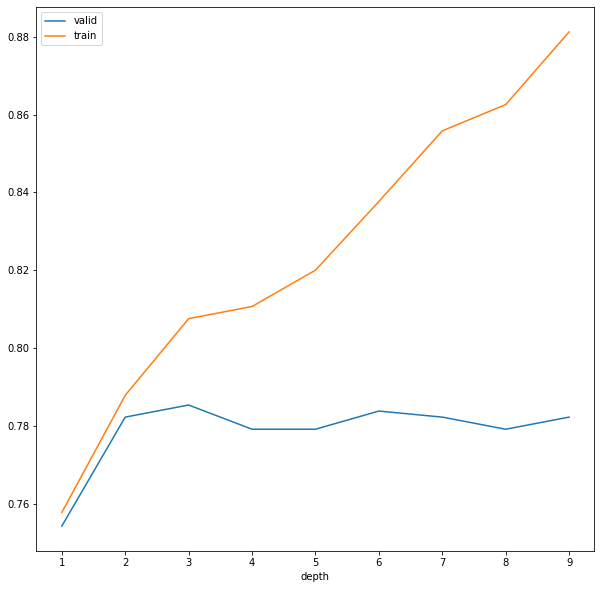

In [47]:
list_for_plot = list(zip(depth_list, valid_list, train_list))
plot_df = pd.DataFrame(list_for_plot, columns=['depth', 'valid', 'train'])
plot_df.plot(x='depth', y=['valid','train'], kind='line', figsize = (10,10));

**Вывод:** Используя "Решающее дерево" мы имеем высокий показатель точности, что может говорить о корректном обучении модели, также стоит отметить высокую скорость обучения у данного типа модели.

### Обучим модель случайному лесу с различными значениями глубины и количества деревьев

In [10]:
%%time
best_model_random_forest = None
best_result_random_forest = 0
depth_max = None
est_max = None

# Пройдемся по циклу перебрав значения количества деревьев 
for est in range(10, 101, 10):
    # Пройдемся по циклу перебрав значения глубины дерева 
    for depth in range(1, 15):
        model_rf = RandomForestClassifier(
            random_state=12345, n_estimators=est, max_depth=depth)  # Определяем тип модели
        # Обучаем модель на обучающей выборке
        model_rf.fit(features_train, target_train)
        # Предсказываем результаты с помощью модели на валидационной выборке
        predictions_valid_rf = model_rf.predict(features_valid)
        # Получаем результат точности модели
        result_rf = accuracy_score(target_valid, predictions_valid_rf)
        if result_rf > best_result_random_forest:  # Записываем налиучшие результаты
            best_model_random_forest = model_rf
            best_result_random_forest = result_rf
            est_max = est
            depth_max = depth

print("Точность на валидационной выборке:", best_result_random_forest, "Количество деревьев:", est_max, "Максимальная глубина:", depth_max)

Точность на валидационной выборке: 0.8087091757387247 Количество деревьев: 40 Максимальная глубина: 8
CPU times: user 19.5 s, sys: 172 ms, total: 19.7 s
Wall time: 19.7 s


**Вывод:** Используя "Случайный лес", мы получили более высокий показатель точности, относительно других моделей обучения, однако можно заметить низкую скорость обучения, которая связана с большей обработкой данных при нахождении лучших гиперпараметров.

### Обучим модель логистической регрессии

In [11]:
%%time
model_lr = LogisticRegression(random_state=12345)

# Обучаем модель на обучающей выборке
model_lr.fit(features_train, target_train)
# Предсказываем результаты с помощью модели на валидационной выборке
predictions_valid_lr = model_lr.predict(features_valid)
# Получаем результат точности модели
result_lr = accuracy_score(target_valid, predictions_valid_lr)
        
print("Точность на валидационной выборки:", result_lr)




Точность на валидационной выборки: 0.7107309486780715
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 21.4 ms


**Вывод:** Используя модель "Логистическая регрессия" мы получили наименьшую точность из всех моделей, но самую высокую скорость обучения.

**Исследуя модели машинного обучения мы получили следующие выводы:**  
 * "Дерево решений" имеет средний уровень скорости обучения и среднее значение точности
 * "Случайный лес" самый медленный из всех, однако имеет лучший результат в точности
 * "Логистическая регрессия" самая быстродейственная, но имеет худший показатель точности
 ---
Исходя из вышеперечисленного можно сделать выбор в пользу модели **"Случайный лес"**, имеющей следующие **гиперпараметры**:
 * Количество деревьев: 40 
 * Максимальная глубина: 8
---
И далее использовать эту модель на тестовой выборке.

## Проверьте модель на тестовой выборке

Наилучшей моделью оказалась `RandomForest`, поэтому именно с ней проведём проверку на тестовой выборке

In [12]:
test_prediction_rf = best_model_random_forest.predict(features_test)

print('Точность предсказания модели RandomForest на тестовой выборке:', accuracy_score( target_test, test_prediction_rf))

Точность предсказания модели RandomForest на тестовой выборке: 0.7962674961119751


## Проверьте модели на адекватность

In [52]:
dummy_model = DummyClassifier(strategy="most_frequent")  # Определяем тип модели
dummy_model.fit(features_train, target_train) 

# Предсказываем целевые признаки используя валидационные признаки
dummy_predict = dummy_model.predict(features_valid)

print('Точность на валидационной выборке:', accuracy_score(target_valid, dummy_predict))
print('Точность на тестовой выборке:', accuracy_score(target_test, dummy_predict))  

Точность на валидационной выборке: 0.7060653188180405
Точность на тестовой выборке: 0.6842923794712286


Показатель точности DummyClassifier ниже, чем у остальных моделей, поэтому можно считать, что все наши модели прошли проверку на адекватность

## Общий вывод:
По результатам исследования можно сделать оценку используемых моделей:
 * **Оценка модели "Решающее дерево":**  
   * Средний показатель скорости
   * Средний показатель качества
   ---
 * **Оценка модели "Случайный лес":**
   * Самый низкий показатель скорости
   * Самая высокое качество модели
   ---
 * **Оценка модели "Логистическая регрессия":**
   * Самая быстрая модель
   * Наименьшее значение качества модели